# Анализ и прогнозирование временных рядов. Модель ARIMA

Этот Jupyter Notebook демонстрирует процесс построения модели ARIMA для различных временных рядов.

---

**DISCLAIMER!**

Процесс определения оптимальных параметров модели ARIMA нельзя назвать абсолютно точным! Как и в случае с оптимизацией гиперпараметров моделей машинного обучения, это скорее ряд рекомендаций, как выбрать тот или иной параметр, а не чёткий (и математически доказанный) алгоритм, который вседа приводит к гарантированно правильному результату. Лучший набор параметров - тот, при котором модель лучше всего соответствует наблюдаемым значениям временного ряда и/или даёт наименьшую ошибку на предсказании.

---

Модель ARIMA($p,d,q$):

$$ A_p(L) \Delta^d X_t = B_q(L)\varepsilon_t $$

Основные параметры модели:

> $p$ - порядок авторегрессии  
> $q$ - порядок скольящего среднего  
> $d$ - порядок интегрирования (при $d = 0$ получаем модель ARMA($p,q$)

Последовательность действий

1. Данные
2. Параметры $d, p, q$
3. Обучение
4. Диагностика
6. Прогноз

Чтобы всё работало, нам потребуется версия `statsmodels` не ниже 0.12.0

In [ ]:
!pip install statsmodels -U

import statsmodels
print(statsmodels.__version__)

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.1)
0.12.1


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import operator
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Данные о потреблении энергии в час PJM West Region: 2001-2018 (PJMW)
Ссылка на Kaggle: https://www.kaggle.com/robikscube/hourly-energy-consumption \
Был взят файл PJMW_hourly.csv

Потребление указано в мегаваттах

### 1. Данные

Загрузка данных, заполнение пропущенных значений.

In [ ]:
pjmw = pd.read_csv('PJMW_hourly.csv', parse_dates=['Datetime'], index_col=['Datetime'])
pjmw.head(20)

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
2002-12-31 06:00:00,5126.0
2002-12-31 07:00:00,5493.0
2002-12-31 08:00:00,5824.0
2002-12-31 09:00:00,5962.0


In [ ]:
pjmw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [ ]:
pjmw.isnull().sum()

PJMW_MW    0
dtype: int64

Пропусков нет

Проверим монотонность индекса

In [ ]:
pjmw.index.is_monotonic

False

In [ ]:
pjmw = pjmw.resample('1D').mean()

In [ ]:
pjmw.index.is_monotonic

True

In [ ]:
pjmw.head()

,PJMW_MW
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000


График значений временного ряда

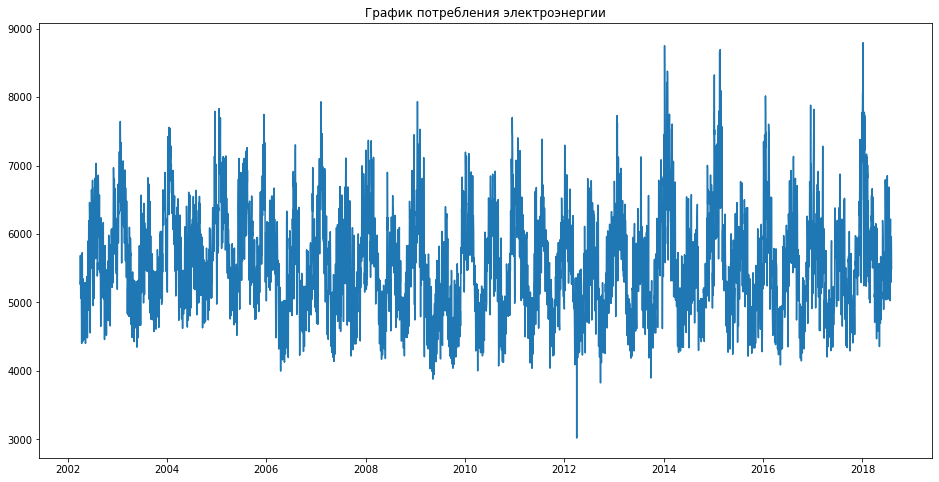

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(pjmw)
plt.title('График потребления электроэнергии')
plt.show()

Посмотрим тренд, сезонность и остатки

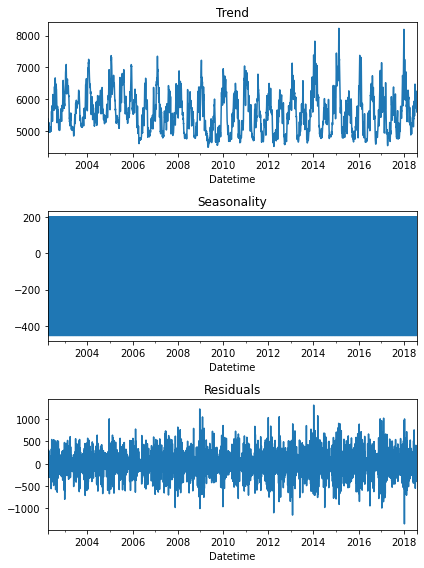

In [ ]:
decomposed = seasonal_decompose(pjmw)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

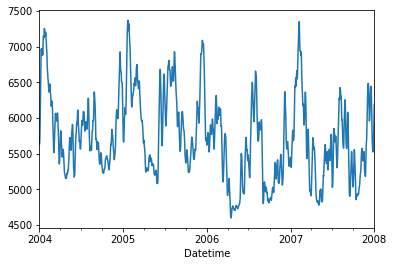

In [ ]:
decomposed.trend['2004-01-01':'2008-01-01'].plot(ax=plt.gca())

Пики в начале года, в тренде есть сезонность тоже

Сезонность по месяцам:

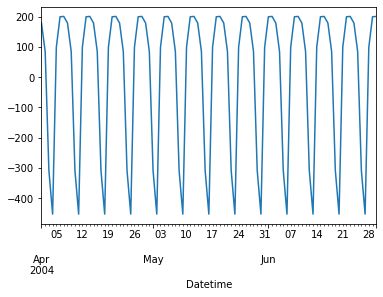

In [ ]:
decomposed.seasonal['2004-04-01':'2004-06-30'].plot(ax=plt.gca())

Сезонность внутри месяца:

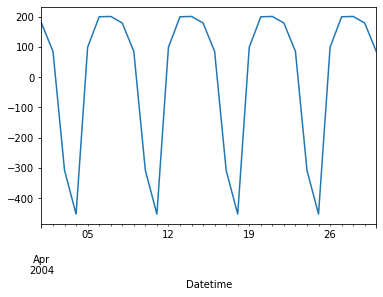

In [ ]:
decomposed.seasonal['2004-04-01':'2004-04-30'].plot(ax=plt.gca())

Сезонность в течение недели:

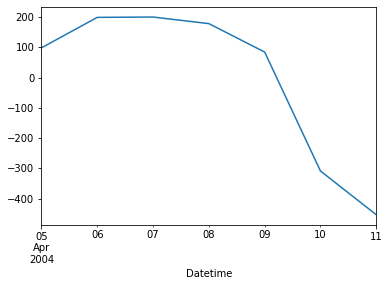

In [ ]:
decomposed.seasonal['2004-04-05':'2004-04-11'].plot(ax=plt.gca())

Недельная сезонность

Попробуем поработать с рядом без сезонности, для этого соединим тренд и остатки ряда

In [ ]:
ts_without_season = decomposed.trend + decomposed.resid

In [ ]:
ts_without_season.index.min()

Timestamp('2002-04-01 00:00:00', freq='D')

In [ ]:
ts_without_season.index.max()

Timestamp('2018-08-03 00:00:00', freq='D')

In [ ]:
ts_without_season.index.is_monotonic

True

Индекс монотонно возрастает. Проверим, есть ли пропуски

In [ ]:
ts_without_season[ts_without_season.isnull()]

Datetime
2002-04-01   NaN
2002-04-02   NaN
2002-04-03   NaN
2018-08-01   NaN
2018-08-02   NaN
2018-08-03   NaN
dtype: float64

In [ ]:
ts_without_season.head()

Datetime
2002-04-01            NaN
2002-04-02            NaN
2002-04-03            NaN
2002-04-04    5492.228491
2002-04-05    5601.512298
Freq: D, dtype: float64

Первые три дня и последние три дня пропущены.

Какие могут быть варианты:
1. Дропнуть эти строки, так как их всего 6, 3 из которых последние, а конец ряда мы будем предсказывать
2. 3 первых заполнить back fill'ом, 3 последних forward fill'ом.
3. Заполнить первые, дропнуть последние

Попробуем 3 вариант:

In [ ]:
ts_without_season.bfill(inplace=True)

In [ ]:
ts_without_season.dropna(inplace=True)

In [ ]:
ts_without_season

Datetime
2002-04-01    5492.228491
2002-04-02    5492.228491
2002-04-03    5492.228491
2002-04-04    5492.228491
2002-04-05    5601.512298
                 ...     
2018-07-27    5894.137298
2018-07-28    5794.137611
2018-07-29    5746.682250
2018-07-30    5394.180759
2018-07-31    5461.538356
Freq: D, Length: 5966, dtype: float64

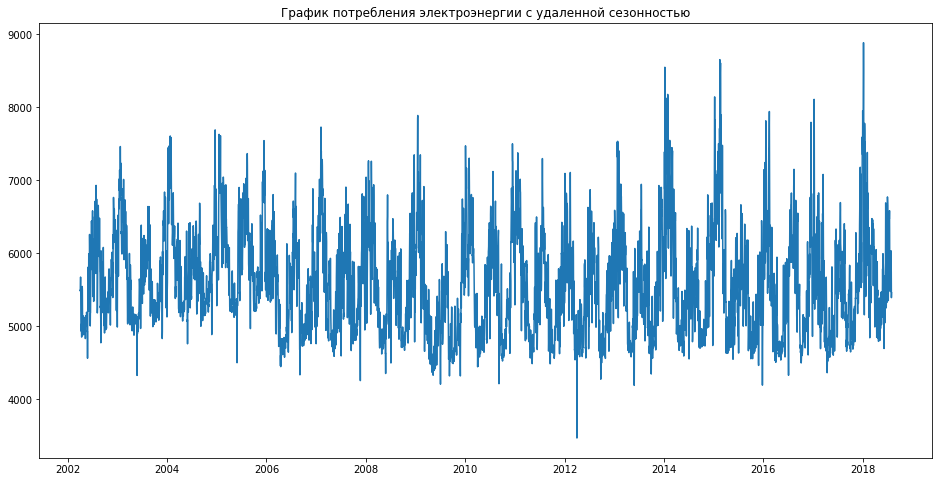

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(ts_without_season)
plt.title('График потребления электроэнергии с удаленной сезонностью')
plt.show()

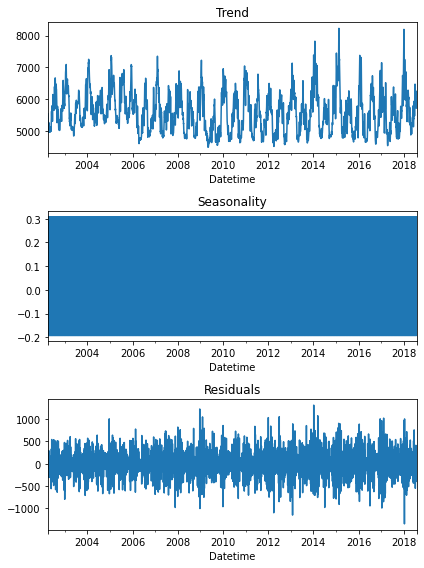

In [ ]:
decomposed = seasonal_decompose(ts_without_season)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

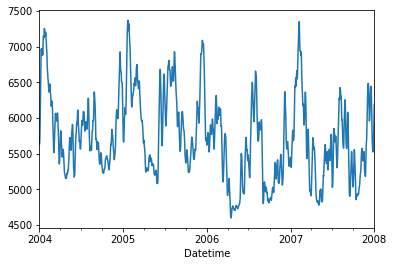

In [ ]:
decomposed.trend['2004-01-01':'2008-01-01'].plot(ax=plt.gca())

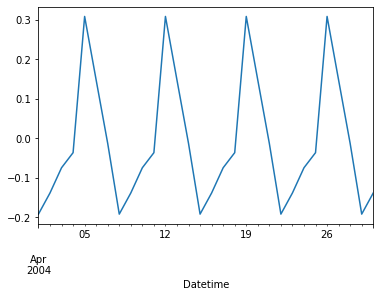

In [ ]:
decomposed.seasonal['2004-04-01':'2004-04-30'].plot(ax=plt.gca())

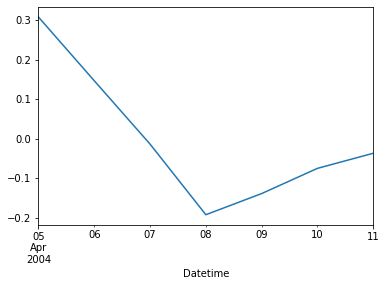

In [ ]:
decomposed.seasonal['2004-04-05':'2004-04-11'].plot(ax=plt.gca())

Упс, сезонность то все равно есть, возможно, стоит тогда SARIMAX пробовать.

### 2. Параметры $d, p, q$

Определяем параметры модели ARIMA: $d, p, q$ (именно в этом порядке: сначала $d$, потом $p$ и $q$)

#### 2.1. Параметр $d$

Нужное нам значение параметра $d$ - это степень оператора разности, который нужно применить к исходному временному ряду, чтобы он стал стационарным. Начинаем с $d = 0$, т.е. сначала тестируем на стационарность иходный временной ряд. Если он не стационарный, то переходим к ряду первых разностей ($d = 1$) и тестируем его. И так далее.

Стационарность проверяем тестом Дики-Фуллера (`statsmodels.tsa.stattools.adfuller`), при этом для параметра `regression` можно использовать значение по умолчанию `'c'` (регрессия с константой) или `'nc'` (регрессия без константы).

Тест на стационарность исходного временного ряда. Если в результатах теста получаем `p_value` $ < 0.05 $ 

In [ ]:
d = 0
ts = pjmw['PJMW_MW']

# function "adfuller()" returns a tuple containing these values. The most interesting for us is the "p_value"
test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts, regression='ctt')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))
if p_value < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд не является стационарным, переходим к следующему значению d')

d = 0. Stationarity test p_value: 7.711115073817453e-09
Ряд стационарный


In [ ]:
d = 0


# function "adfuller()" returns a tuple containing these values. The most interesting for us is the "p_value"
test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts_without_season, regression='ctt')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))
if p_value < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд не является стационарным, переходим к следующему значению d')

d = 0. Stationarity test p_value: 6.516805267737338e-10
Ряд стационарный


Исходный временной ряд является стационарным, поэтому дальнейший поиск d не требуется.

Для нашего пробного ряда тоже условия соблюдаются

$d = 0$



#### 2.2. Параметр $p$

Чтобы оценить порядок авторегрессии в модели ARIMA, нужно построть график частной автокорреляционной функции для ряда разностей порядка $d$ (грубо горовя, для того ряда разностей, который получился стационарным).

В теории, для процесса авторегрессии порядка $p$ значения частной автокорреляционной функции равны нулю для всех $\tau > p$. Таким образом, используя график частной автокорреляционной функции для временного ряда разностей порядка $d$, можно оценить параметр $p$ как значение лага $\tau$ (значение по оси абсцисс), после которого значения частной автокорреляционной функции равны (или почти равны) нулю.

Естественно, такой метод оценки не является абсолютно точным. В случае, когда нельзя однозначно определить, поске какого лага $\tau$ все значения частной автокорреляции можно считать нулевыми, можно выбрать несколько (два или три) значений-кандидатов параметра $p$, построить несколько моделей ARIMA с выбранными параметрами и выбрать, какая из них лучше.

Mожно использовать функцию `statsmodels.graphics.tsaplots.plot_pacf`

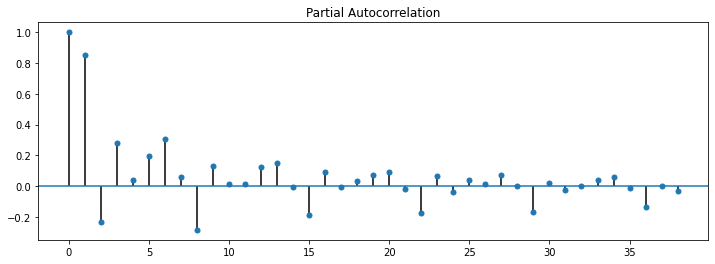

In [ ]:
plot_pacf(ts, alpha=None).set_size_inches(12, 4)
plt.show()

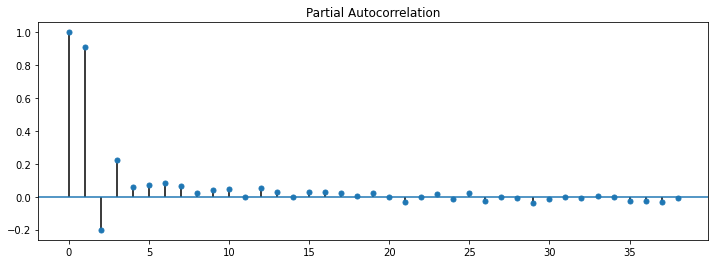

In [ ]:
plot_pacf(ts_without_season, alpha=None).set_size_inches(12, 4)
plt.show()

Можно предположить, что $p = 1$

#### 2.3. Параметр $q$

Аналогично, чтобы оценить порядок скользящего среднего в модели ARIMA, нужно построть график автокорреляционной функции для ряда разностей порядка $d$ (грубо горовя, для того ряда разностей, который получился стационарным).

В теории, для процесса скользящего среднего порядка $q$ значения частной автокорреляционной функции равны нулю для всех $\tau > q$. Таким образом, используя график автокорреляционной функции для временного ряда разностей порядка $d$, можно оценить параметр $q$ как значение $\tau$ (значение по оси абсцисс), после которого значения автокорреляционной функции равны (или почти равны) нулю.

Аналогично предыдущему пункту, такой метод оценки не является абсолютно точным. В случае, когда нельзя однозначно определить параметр $p$, можно выбрать несколько (два или три) значений-кандидатов и построить несколько моделей ARIMA.

Mожно использовать функцию `statsmodels.graphics.tsaplots.plot_acf`

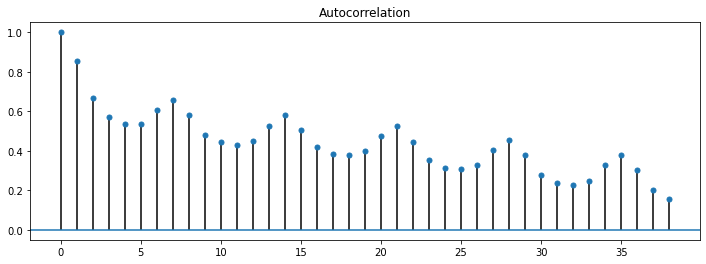

In [ ]:
plot_acf(ts, alpha=None).set_size_inches(12, 4)
plt.show()

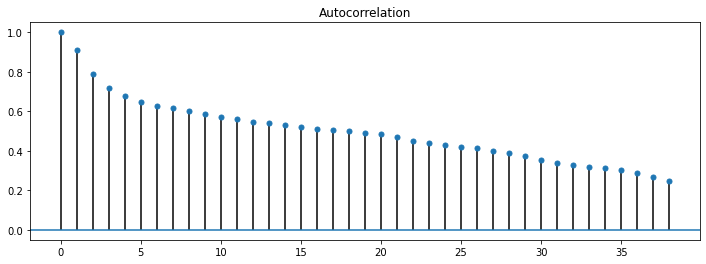

In [ ]:
plot_acf(ts_without_season, alpha=None).set_size_inches(12, 4)
plt.show()

Большое количество значений подходит, но выбор слишком больших параметров усложнит модель. Оставим 10 значений

#### 2.4. Итого, параметры $d,p,q$

> $d = 0$  
> $p = 1 $  
> $1 \leq q \leq 10 $  

В результате, получается, что для временного ряда коэффициентов обслуживания долга мы должны построить несколько моделей ARIMA($p,0,q$) (она же ARMA($p, q$)) для разных значений параметров $p$ и $q$ (если мы хотим перебрать все возможные комбинации параметров, то нужно будет построить 10 моделей).

Еще посмотрим SARIMAX

### 3. Обучение

Теперь, зная значения параметров $d$, $p$ и $q$, мы можем построить модель ARIMA($p,d,q$) для временного ряда.


Так как у нас есть несколько возможных комбинаций, имеет смысл построить несколько моделей с разными значениями параметров и сравнить, насколько хорошо та или иная модель описывает наблюдаемый временной ряд.

В качестве критерия ставнения можно использовать один из критериев:

* **Правдоподобие** (**Likelihood** или **Log Likelihood**) - больше значит лучше
* **Информационный критерий Акаике** (**AIC**) - меньше значит лучше
* **Байесовский информационный критерий** (**BIC**) - меньше значит лучше

Следует участь, что информационные критерии дополнительно штрафуют модель за количество переменых.

Для начала, построим и сравним 2 модели ARIMA: с минимальными значениями $p$ и $q$ и с максимальными.

Для исходного ряда:

In [ ]:
# ARIMA(1, 0, 1)
model_min = ARIMA(pjmw['PJMW_MW'], order=(1,0,1)).fit()
print(model_min.summary())

                               SARIMAX Results                                
Dep. Variable:                PJMW_MW   No. Observations:                 5969
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -43683.971
Date:                Sun, 27 Dec 2020   AIC                          87375.941
Time:                        22:58:07   BIC                          87402.718
Sample:                    04-01-2002   HQIC                         87385.243
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5602.2783     27.920    200.657      0.000    5547.557    5657.000
ar.L1          0.7443      0.009     82.822      0.000       0.727       0.762
ma.L1          0.4290      0.013     33.624      0.0

In [ ]:
# ARIMA(1, 0, 10)
model_max = ARIMA(pjmw['PJMW_MW'], order=(1,0,10)).fit()
print(model_max.summary())

                               SARIMAX Results                                
Dep. Variable:                PJMW_MW   No. Observations:                 5969
Model:                ARIMA(1, 0, 10)   Log Likelihood              -43059.503
Date:                Sun, 27 Dec 2020   AIC                          86145.006
Time:                        22:58:38   BIC                          86232.033
Sample:                    04-01-2002   HQIC                         86175.236
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5602.2752     78.633     71.246      0.000    5448.158    5756.392
ar.L1          0.9794      0.004    245.516      0.000       0.972       0.987
ma.L1          0.0905      0.012      7.302      0.0

Интересно, что и по информационным критериям, и по правдоподобию побеждает более сложная модель. Заметим, что p_value в 4 столбце при всех параметрах по нулям

Для ряда, где мы пробовали вырезать сезонность

In [ ]:
# ARIMA(1, 0, 1)
model_min = ARIMA(ts_without_season, order=(1,0,1)).fit()
print(model_min.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5966
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -42097.165
Date:                Sun, 27 Dec 2020   AIC                          84202.330
Time:                        22:58:39   BIC                          84229.106
Sample:                    04-01-2002   HQIC                         84211.631
                         - 07-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5602.3323     36.003    155.608      0.000    5531.768    5672.897
ar.L1          0.8554      0.007    129.578      0.000       0.843       0.868
ma.L1          0.3173      0.010     30.878      0.0

In [ ]:
# ARIMA(1, 0, 10)
model_max = ARIMA(ts_without_season, order=(1,0,10)).fit()
print(model_max.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5966
Model:                ARIMA(1, 0, 10)   Log Likelihood              -41932.407
Date:                Sun, 27 Dec 2020   AIC                          83890.814
Time:                        22:58:46   BIC                          83977.834
Sample:                    04-01-2002   HQIC                         83921.042
                         - 07-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5602.3323     80.501     69.593      0.000    5444.553    5760.112
ar.L1          0.9779      0.004    246.341      0.000       0.970       0.986
ma.L1          0.1236      0.011     11.175      0.0

Здесь с критериями аналогично, но p value высокий в ma.L7, ma.L10

Пробуем SARIMAX \
Формула такая: $(p,d,q)×(P,D,Q)s.$ \
Параметр s используется так: (насколько я понял)
* 1 для годовой (но 1 нельзя использовать, ошибка вылезает)
* 4 для квартальной
* 12 для месячной
* 52 для недельной
* 365 для дневной

У нас недельная сезонность, попробуем $s = 52$

Модель, получается, будет сложная, поэтому не будем менять значение q, оставим единицу
Смотреть будем только на исходном ряду

In [ ]:
%%time
# SARIMAX(1, 0, 1, 52)
sarimax_52 = SARIMAX(pjmw['PJMW_MW'], 
                    order=(1, 0, 1), 
                    seasonal_order=(1,0,1,52),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()
print(sarimax_52.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            PJMW_MW   No. Observations:                 5969
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood              -43640.750
Date:                            Sun, 27 Dec 2020   AIC                          87291.499
Time:                                    22:59:42   BIC                          87324.926
Sample:                                04-01-2002   HQIC                         87303.116
                                     - 08-03-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9975      0.001   1058.557      0.000       0.996       0.999
ma.L1          0.3099      0.013   

Значения критериев как-то не супер, посмотрим с $s=12$ по месяцам

In [ ]:
%%time
# SARIMAX(1, 0, 1, 12)
sarimax_12 = SARIMAX(pjmw['PJMW_MW'], 
                    order=(1, 0, 1), 
                    seasonal_order=(1,0,1,12), 
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()
print(sarimax_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            PJMW_MW   No. Observations:                 5969
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -43830.990
Date:                            Sun, 27 Dec 2020   AIC                          87671.980
Time:                                    22:59:46   BIC                          87705.440
Sample:                                04-01-2002   HQIC                         87683.604
                                     - 08-03-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.001   1152.652      0.000       0.996       1.000
ma.L1          0.2678      0.013   

Возьмем $s=2$:

In [ ]:
%%time
# SARIMAX(1, 0, 1, 2)
sarimax_1 = SARIMAX(pjmw['PJMW_MW'], 
                    order=(1, 0, 1), 
                    seasonal_order=(1,0,1,2), 
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit()
print(sarimax_1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           PJMW_MW   No. Observations:                 5969
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 2)   Log Likelihood              -43610.643
Date:                           Sun, 27 Dec 2020   AIC                          87231.286
Time:                                   22:59:48   BIC                          87264.755
Sample:                               04-01-2002   HQIC                         87242.912
                                    - 08-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.000   2133.173      0.000       0.999       1.000
ma.L1          0.0747      0.015      4.964

О, AIC и BIC уменьшились, правдоподобие увеличилось, стало лучше

#### 3.1. Поиск по сетке

Простой перебор параметров модели (может выполняться долго)

In [ ]:
%%capture
# List of parameter tuples (p, d, q)
params_list = [(1, 0, q) for q in range(10)]

# Dictionary of {parameter tuple : fitted model}
models_dict = {params: ARIMA(pjmw['PJMW_MW'], order=params).fit() for params in params_list}

best_llf = max(models_dict.items(), key=lambda x: x[1].llf)[0]
best_aic = min(models_dict.items(), key=lambda x: x[1].aic)[0]

In [ ]:
print("Best Log Likelihood: ARIMA{}".format(best_llf))
models_dict[best_llf].summary()

Best Log Likelihood: ARIMA(1, 0, 9)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:                 5969
Model:                 ARIMA(1, 0, 9)   Log Likelihood              -43072.140
Date:                Sun, 27 Dec 2020   AIC                          86168.280
Time:                        23:01:48   BIC                          86248.613
Sample:                    04-01-2002   HQIC                         86196.185
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5602.2752     77.516     72.272      0.000    5450.346    5754.204
ar.L1          0.9778      0.004    246.763      0.000       0.970       0.986
ma.L1          0.0824      0.012      6.652      0.000       0.058       0.107
ma.L2         -0.4002      0.013    -31.443      0.000      -0.425      -0.375
ma.L3         -0.2368      0.013    -18.667      0.000      -0.262      -0.212
ma.L4         -0.1054      0.013     -8.385      0.000      -0.130      -0.081
ma.L5         -0.0749      0.013     -5.775      0.000      -0.100      -0.049
ma.L6         -0.0236      0.013     -1.867      0.062      -0.048       0.001
ma.L7          0.2791      0.012     23.266      0.000       0.256       0.303
ma.L8          0.0194      0.013      1.538      0.124      -0.005       0.044
ma.L9         -0.1649      0.012    -13.546      0.000      -0.189      -0.141
sigma2      1.084e+05   1669.808     64.920      0.000    1.05e+05    1.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               315.24
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print("Best AIC: ARIMA{}".format(best_aic))
models_dict[best_aic].summary()

Best AIC: ARIMA(1, 0, 9)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:                 5969
Model:                 ARIMA(1, 0, 9)   Log Likelihood              -43072.140
Date:                Sun, 27 Dec 2020   AIC                          86168.280
Time:                        23:01:48   BIC                          86248.613
Sample:                    04-01-2002   HQIC                         86196.185
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5602.2752     77.516     72.272      0.000    5450.346    5754.204
ar.L1          0.9778      0.004    246.763      0.000       0.970       0.986
ma.L1          0.0824      0.012      6.652      0.000       0.058       0.107
ma.L2         -0.4002      0.013    -31.443      0.000      -0.425      -0.375
ma.L3         -0.2368      0.013    -18.667      0.000      -0.262      -0.212
ma.L4         -0.1054      0.013     -8.385      0.000      -0.130      -0.081
ma.L5         -0.0749      0.013     -5.775      0.000      -0.100      -0.049
ma.L6         -0.0236      0.013     -1.867      0.062      -0.048       0.001
ma.L7          0.2791      0.012     23.266      0.000       0.256       0.303
ma.L8          0.0194      0.013      1.538      0.124      -0.005       0.044
ma.L9         -0.1649      0.012    -13.546      0.000      -0.189      -0.141
sigma2      1.084e+05   1669.808     64.920      0.000    1.05e+05    1.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               315.24
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
best_model = models_dict[best_aic]

Лучшей моделью как по правдоподобию, так и по информационному критерию, оказалась ARIMA(1, 0, 9).

### 4. Прогноз

После того, как мы обучили модель, мы можем использовать методы `predict()` и `forecast()` для предсказания **мат. ожидания** значений процесса.

Метод `predict()` позволяет предсказывать значения внутри указанного временного диапазона, который может как быть полностью внутри границ временного ряда, так и выходить за его пределы.

Это удобно использовать для сравнения предсказанных значений с известными.

#### 4.1. Предсказание на 1 шаг

Постоим предсказание на 1 шаг вперед для всего временного ряда: в каждой точке мы будем предсказывать только одно значение на основе предыдущих **известных** значений.

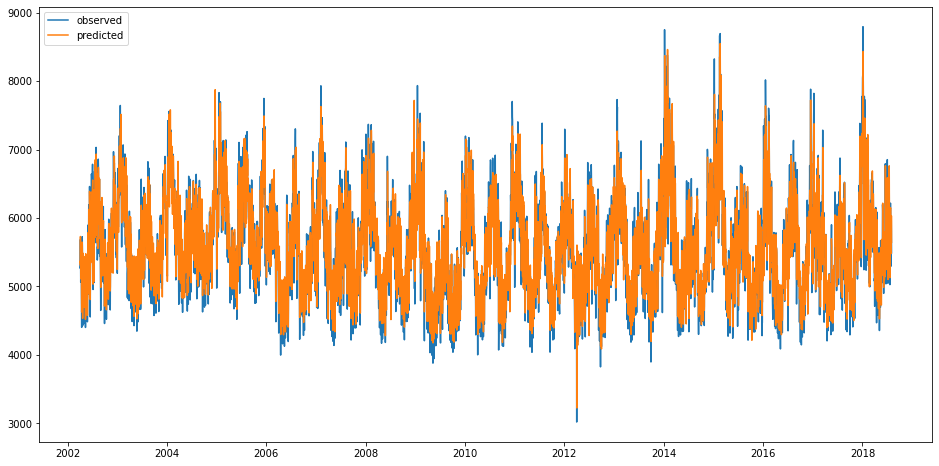

In [ ]:
arima_prediction = best_model.predict(start=1)
plt.figure(figsize=(16,8))
plt.plot(pjmw['PJMW_MW'], color='tab:blue', label='observed')
plt.plot(arima_prediction, color='tab:orange', label='predicted')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
mae(pjmw['PJMW_MW'][1:], arima_prediction)

254.80346509087713

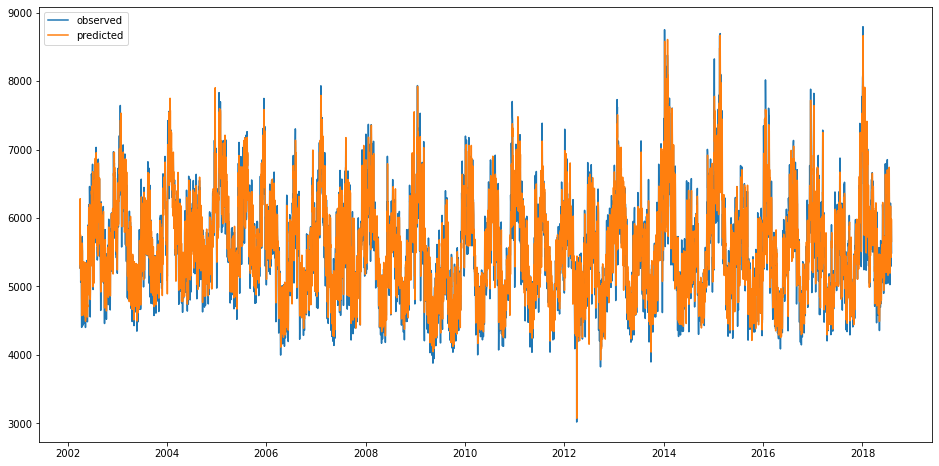

In [ ]:
sarimax_prediction = sarimax_1.predict(start=1)
plt.figure(figsize=(16,8))
plt.plot(pjmw['PJMW_MW'], color='tab:blue', label='observed')
plt.plot(sarimax_prediction, color='tab:orange', label='predicted')
plt.legend()
plt.show()

In [ ]:
mae(pjmw['PJMW_MW'][1:], sarimax_prediction)

277.2312636145392

По графику достаточно сложно определить попадалки моделей, вроде, даже неплохо. А сравнение метрики MAE показывает, что ARIMA превзошла SARIMAX 

#### 4.2. Предсказание на несколько шагов

Теперь построим предсказание для периода 2018 - 2020 гг. (730 точек). Как видно, этот период выходит за пределы временного ряда. На этот раз каждое следущее предсказание (кроме начального) будет строится на остнове предыдущих **предсказанных** значений.


In [ ]:
prediction_steps = 730
prediction_dates = pd.date_range(start='2018-06-01', periods=prediction_steps, freq='D')
prediction = pd.DataFrame(best_model.predict(start=prediction_dates[0], end=prediction_dates[-1], dynamic=4), index=prediction_dates)

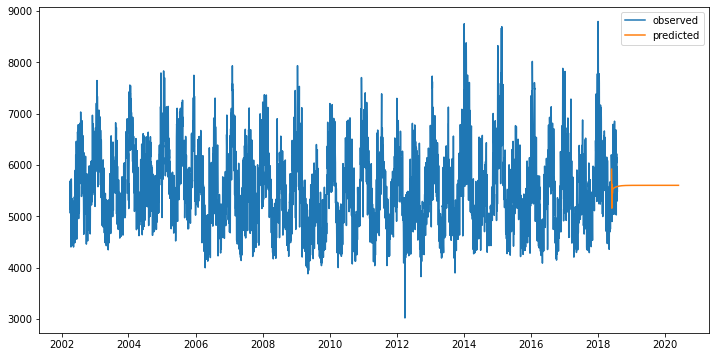

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(pjmw['PJMW_MW'], color='tab:blue', label='observed')
plt.plot(prediction, color='tab:orange', label='predicted')
plt.legend()
plt.show()

Наконец, посмотрим, как ведёт себя ошибка предсказания в этом случае. Для этого мы отобразим на графике 95% доверительный интервал для предсказанных значений.

In [ ]:
prediction_obj = best_model.get_prediction(start=prediction_dates[0], end=prediction_dates[-1], dynamic=0)
prediction = pd.DataFrame({'mean': prediction_obj.predicted_mean, 'var': prediction_obj.var_pred_mean}, index=prediction_dates)

# Calculate 95% confidence interval
prediction['lower'] = prediction['mean'] - 1.96 * np.sqrt(prediction['var'])
prediction['upper'] = prediction['mean'] + 1.96 * np.sqrt(prediction['var'])

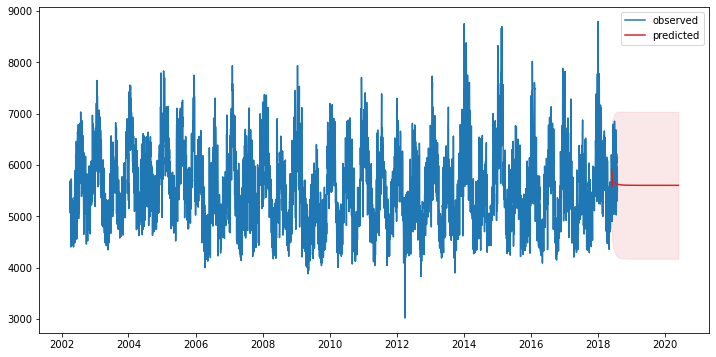

In [ ]:
plt.figure(figsize=(12, 6))
plt.fill_between(prediction.index, prediction['lower'], prediction['upper'], alpha=0.1, color='tab:red')
plt.plot(pjmw['PJMW_MW'], color='tab:blue', label='observed')
plt.plot(prediction['mean'], color='tab:red', label='predicted')
plt.legend()
plt.show()

Можно считать, что модель думает, что в среднем около 5500 будет держаться значение, доверительный интервал попадает в размах 2018 года